# Explore Latent Dirichlet Allocation (LDA) with NIPS Papers

In [7]:
!pip install wordcloud
!pip install gensim
!pip install pyldavis
!pip install spacy
!pip install pdfplumber

In [1]:
# Importing modules
import pandas as pd
import os
from os import listdir
import pprint
import pickle
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Load the regular expression library
import re

# Import the wordcloud library
from wordcloud import WordCloud

# Package contains interfaces and functionality to compute pair-wise document similarities within a corpus of documents
import gensim
from gensim.utils import simple_preprocess

# Natural Language Toolkit
import nltk
nltk.download('stopwords') # if Package stopwords do not exist
from nltk.corpus import stopwords

# For LDA VisualisationpyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
import pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roydo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
!python -m spacy download en_core_web_sm

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Section A : Extract texts from PDF files to create document repository

In [23]:
!pip install pdfplumber

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Created wheel for pdfplumber: filename=pdfplumber-0.6.0-py3-none-any.whl size=33674 sha256=8dee7c10b16d8836b4d29df16a563f4597a0b432c8317d1caa0de05a2da6b457
  Stored in directory: c:\users\roydo\appdata\local\pip\cache\wheels\42\74\b8\c95f716311b9ee587844cd73381fc19079bccfc05110378c61
Successfully built pdfplumber
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1


In [3]:
# https://github.com/jsvine/pdfplumber
import pdfplumber

pdfToText = ''
# pdf_filename = '/kaggle/input/nips-papers/LDAvis.pdf'
PDF_DIR_PATH = 'C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/'
pdf_text_df = pd.DataFrame(columns=['pdf_name', 'total_pages', 'doc_text', 'chars'])

pdf_text_dict = {}

filenames = [fname for fname in listdir(PDF_DIR_PATH) if os.path.isfile(PDF_DIR_PATH+fname)]
pdf_filenames = filter(lambda fname: fname.endswith(('.pdf','.PDF')), filenames)
list_pdf_filenames = list(pdf_filenames)

for pdf_filename in list_pdf_filenames:
    with pdfplumber.open(PDF_DIR_PATH + pdf_filename) as pdf:
        # Reset the extracted text
        pdfToText = ''
        for page in pdf.pages:
            pdfToText += page.extract_text()

        # Extract single page
        # first_page = pdf.pages[0]
        # print(first_page.extract_text())
        # type(pdf), type(first_page)

        # Store extracted texts for each pdf file
        pdf_text_dict['pdf_name'] = pdf_filename
        pdf_text_dict['total_pages'] = len(pdf.pages)
        pdf_text_dict['doc_text'] = pdfToText
        pdf_text_dict['chars'] = len(pdfToText)

        pdf_text_df = pdf_text_df.append(pdf_text_dict, ignore_index=True, sort=False)
        # Some texts are joint into a word and column texts need to be manipulated
        print("Texts can be extracted from {} pages in \'{}\'".format(len(pdf.pages), pdf_filename))
        print("-" * 100)

pdf_text_df

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-3-0fc2efeadd2a>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pdf_text_df = pdf_text_df.append(pdf_text_dict, ignore_index=True, sort=False)


Texts can be extracted from 8 pages in 'HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf'
----------------------------------------------------------------------------------------------------
Texts can be extracted from 8 pages in 'LDAvis.pdf'
----------------------------------------------------------------------------------------------------


<ipython-input-3-0fc2efeadd2a>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pdf_text_df = pdf_text_df.append(pdf_text_dict, ignore_index=True, sort=False)


,pdf_name,total_pages,doc_text,chars
0,HogRider_Champion Agent of Microsoft Malmo Col...,8,HogRider: Champion Agent of Microsoft Malmo Co...,40377
1,LDAvis.pdf,8,LDAvis: A method for visualizing and interpret...,31350


# Section B : Data Mining

## 1. Load Data

In [4]:
# Load data into papers
papers = pd.read_csv('C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/papers.csv')

# papers.shape : (6560, 8)
papers.head()

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


## 2. Data Cleaning for NLP

In [5]:
# Keep only the required columns and obtain first 500 samples [:500]
samples = papers.shape[0]
papers_text_df = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)

# Or get random samples with papers.sample(samples)
papers_text_df.head()

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


### Remove punctuations and lower casing
* Perform a simple preprocessing on the content of "paper_text" column to make them more amenable for analysis. Use a regular expression to remove any punctuations and lowercase text.  We might also want to remove plurality.

In [6]:
# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\\.!?]', '', x)) # replace \ with \\

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

# papers['paper_text_processed'].iloc[0]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

## 3. Exploratory Data Analysis (EDA)

* Using the wordcloud package to have a visual representation of most common words.  It is important to understand the data and ensure that we are on the right track.  Further preprocessing might be required before training the model.

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\NTU Tutori

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed

Wall time: 1min 50s


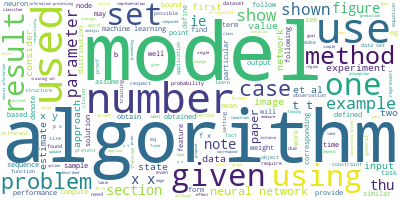

In [7]:
%%time
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Save in default kaggle directory, "/kaggle/working/"
wordcloud.to_file('wordcloud_' + str(samples) + '_samples.png')

# Visualize the word cloud
wordcloud.to_image()

# Ref : https://www.datacamp.com/community/tutorials/wordcloud-python

## 4. Prepare text for Latent Dirichlet Allocation (LDA)

* Transform the textual data in a format that will serve as an input for training a LDA model.
> * Tokenizing the text and removing stopwords
> * Convert the tokenized object into a corpus and dictionary

In [8]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
stop_words = stopwords.words('english')

# Customise to included other stop words
stop_words.extend(['from', 'subject', 're', 'edu', 'use',
                   'hisashi', 'suzuki', 'suguru', 'arimoto', 'university']) # Remove some author names

# Exracting words from sentences and preprocessing
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True will remove punctuations
        # yield returns a generator that produces the words for each paper_text
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Peform n-grams and lemmatization
def get_data(data_words):
    """
    Get Bigram Model, lemmatization mapping
    """
    # Remove stop words from data_words
    data_words_nostops = remove_stopwords(data_words)
    print("After removing stop words :\n", data_words_nostops[:1][0][:30])
    print()

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    print("After making bigrams :\n", data_words_bigrams[:1][0][:30])
    print()
    
    # Do lemmatization keeping only noun, adj, vb, adv
    data_words_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    print("After lemmatization :\n", data_words_lemmatized[:1][0][:30])

    return data_words_bigrams, data_words_lemmatized

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
%%time
# Store all paper_text from samples into list
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
print("Before removing stop words for {} documents with sample :\n{}".format(len(data_words), data_words[:1][0][:30]))

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before removing stop words for 6560 documents with sample :
['self', 'organization', 'of', 'associative', 'database', 'and', 'its', 'applications', 'hisashi', 'suzuki', 'and', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'an', 'efficient', 'method', 'of', 'self', 'organizing', 'associative', 'databases', 'is', 'proposed', 'together']
Wall time: 1min 17s


## 4.1 Phrase Modeling: Bigram and Trigram Models
* Bigrams and Trigrams are 2 and 3 words frequently occurring together in the document.
* Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more.  The two important arguments to Phrases model are min_count and threshold.

In [11]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold gives fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a bigram or trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 3min 3s


In [12]:
%%time
train_bigrams, train_lemmatized = get_data(data_words)

# train_bigrams[0], train_lemmatized[0]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


After removing stop words :
 ['self', 'organization', 'associative', 'database', 'applications', 'osaka', 'toyonaka', 'osaka', 'japan', 'abstract', 'efficient', 'method', 'self', 'organizing', 'associative', 'databases', 'proposed', 'together', 'applications', 'robot', 'eyesight', 'systems', 'proposed', 'databases', 'associate', 'input', 'output', 'first', 'half', 'part']

After making bigrams :
 ['self_organization', 'associative', 'database', 'applications', 'osaka', 'toyonaka', 'osaka_japan', 'abstract', 'efficient', 'method', 'self_organizing', 'associative', 'databases', 'proposed', 'together', 'applications', 'robot', 'eyesight', 'systems', 'proposed', 'databases', 'associate', 'input', 'output', 'first', 'half', 'part', 'discussion', 'algorithm', 'self_organization']

After lemmatization :
 ['self_organization', 'associative', 'database', 'application', 'abstract', 'efficient', 'method', 'self_organize', 'associative', 'database', 'propose', 'together', 'application', 'robot', '

In [13]:
print("\nDimension of train_lemmatized : ({}, {}, {})".format(len(train_lemmatized),
                                                              len(train_lemmatized[0]),
                                                              len(train_lemmatized[0][0])))


Dimension of train_lemmatized : (6560, 1570, 17)


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4.2 Data transformation: Corpus and Dictionary
* The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

In [14]:
import gensim.corpora as corpora

def get_corpus(data_lemmatized):
    """
    Get id2word, corpus mapping
    """
    # Ref : https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.doc2bow.html
    # Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
    # Each word is assumed to be a tokenized and normalized string.
    # No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized) # data_words_nostops, data_words
    print("Created dictionary of size {} with sample word : \'{}\'".format(len(id2word), id2word[0]))
    
    # Filter out tokens that appear in < no_below documents or more than no_above documents (fraction of total corpus size)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    # Calling this method will remove the gaps and make the ids more compact (eg. after some tokens have been removed via filter_extremes)
    id2word.compactify()

    # Create Corpus
    texts =  data_lemmatized # data_words_nostops

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Show the id with the respective frequency
    print("Corpus of {} documents with sample :\n{}".format(len(data_words), corpus[:1][0][:30]))

    return id2word, corpus

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
%%time
train_id2word, train_corpus = get_corpus(train_lemmatized)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Created dictionary of size 128091 with sample word : 'abolish'
Corpus of 6560 documents with sample :
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 6), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 7), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 13), (25, 1), (26, 3), (27, 2), (28, 1), (29, 1)]
Wall time: 18.4 s


In [16]:
#  list of (token_id, token_count) 2-tuples
print(train_corpus[:1][0][:30][:])

print("\nDimension of corpus : ({}, {}, {})".format(len(train_corpus), len(train_corpus[0]),
                                                    len(train_corpus[0][0])))

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 6), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 7), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 13), (25, 1), (26, 3), (27, 2), (28, 1), (29, 1)]

Dimension of corpus : (6560, 395, 2)


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# https://radimrehurek.com/gensim/corpora/dictionary.html
# Vocabulary size, word<->id mappings
print("Size of dictionary, \'train_id2word\' : {} with {} processed words".format(len(train_id2word),
                                                                                  train_id2word.num_pos))

Size of dictionary, 'train_id2word' : 16056 with 12352849 processed words


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# token -> token_id
# train_id2word.token2id

# 'token_id' is the dictionary key
show_dict_items = {token_id: train_id2word[token_id] for token_id in list(train_id2word)[:10]}
show_dict_items

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 'abolish',
 1: 'accelerate',
 2: 'acceptable',
 3: 'accomplish',
 4: 'accordingly',
 5: 'actual',
 6: 'addressing',
 7: 'adjacent',
 8: 'adopt',
 9: 'already'}

In [19]:
train_id2word[316]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'self_organization'

In [20]:
# Save Dictionary to a text file
train_id2word.save_as_text('doc_dictionary.csv')

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
type(train_id2word)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


gensim.corpora.dictionary.Dictionary

* HDP Model - infers the number of topics from the data
1. > Gensim provides a Hierarchical Dirichlet Process (HDP) class which is similar to LDA, except it learns the correct number of topics from the data via Online Variational Bayes Inference.  Thus, we do not need to provide a fixed number of topics (https://radimrehurek.com/gensim/models/hdpmodel.html).
2. > Running HDP on the 100 (or 6,560) papers few times and we use the number of topics it was learning; which is always 20 topics for this dataset.  It does not give a good coherence score compared to manual hyperparameter tuning with number of topics.

In [22]:
%%time
from gensim.models import HdpModel
hdp = HdpModel(train_corpus, train_id2word, chunksize=10000)
len(hdp.print_topics())

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 40.1 s


20

In [23]:
hdp.print_topics(num_topics=len(hdp.print_topics()))

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.004*kernel + 0.003*cluster + 0.002*layer + 0.002*graph + 0.002*neuron + 0.001*topic + 0.001*object + 0.001*target + 0.001*sparse + 0.001*group'),
 (1,
  '0.002*neuron + 0.002*cluster + 0.002*action + 0.002*reward + 0.002*target + 0.001*sparse + 0.001*visual + 0.001*response + 0.001*object + 0.001*cell'),
 (2,
  '0.002*object + 0.002*policy + 0.002*stimulus + 0.002*response + 0.002*kernel + 0.002*graph + 0.002*cluster + 0.001*fig + 0.001*neuron + 0.001*cell'),
 (3,
  '0.002*policy + 0.002*action + 0.002*kernel + 0.001*cluster + 0.001*object + 0.001*classifier + 0.001*topic + 0.001*tree + 0.001*node + 0.001*density'),
 (4,
  '0.002*object + 0.002*layer + 0.001*classifier + 0.001*visual + 0.001*kernel + 0.001*basis + 0.001*pixel + 0.001*code + 0.001*filter + 0.001*graph'),
 (5,
  '0.002*policy + 0.002*action + 0.002*reward + 0.001*gradient + 0.001*cell + 0.001*object + 0.001*arm + 0.001*regret + 0.001*node + 0.001*tree'),
 (6,
  '0.003*cluster + 0.002*graph + 0.002*object + 0.00

## 5. Latent Dirichlet Allocation (LDA) model training

* Start with default parameters except for specifying the number of topics.
> Eg. Build a model with 10 topics whereby each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [24]:
%%time
# number of topics that need to experiment with based on the documents
num_topics = len(hdp.print_topics()) # 7
print("num_topics :", num_topics)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=train_corpus,
                                       id2word=train_id2word,
                                       num_topics=num_topics)

# Print the Keyword in the number of topics
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(lda_model.print_topics())

doc_lda = lda_model[train_corpus]

doc_lda[0]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics : 20
[ ( 0,
    '0.006*"topic" + 0.006*"graph" + 0.005*"layer" + 0.004*"action" + '
    '0.004*"node" + 0.004*"policy" + 0.004*"cluster" + 0.004*"object" + '
    '0.004*"neuron" + 0.003*"field"'),
  ( 1,
    '0.007*"object" + 0.007*"cluster" + 0.005*"target" + 0.004*"visual" + '
    '0.004*"filter" + 0.004*"node" + 0.004*"graph" + 0.003*"location" + '
    '0.003*"neuron" + 0.003*"action"'),
  ( 2,
    '0.007*"kernel" + 0.005*"code" + 0.005*"query" + 0.004*"object" + '
    '0.004*"group" + 0.004*"neuron" + 0.003*"graph" + 0.003*"edge" + '
    '0.003*"rank" + 0.003*"stimulus"'),
  ( 3,
    '0.006*"rank" + 0.005*"graph" + 0.005*"kernel" + 0.004*"neuron" + '
    '0.004*"action" + 0.003*"layer" + 0.003*"target" + 0.003*"classifier" + '
    '0.003*"sparse" + 0.003*"object"'),
  ( 4,
    '0.005*"cluster" + 0.004*"agent" + 0.004*"layer" + 0.004*"gradient" + '
    '0.004*"topic" + 0.004*"target" + 0.004*"policy" + 0.003*"kernel" + '
    '0.003*"group" + 0.003*"face"'),
  ( 5,
    '0.

[(0, 0.38979474),
 (2, 0.023851257),
 (3, 0.021251809),
 (8, 0.102287784),
 (10, 0.118981175),
 (11, 0.0634381),
 (15, 0.0805405),
 (17, 0.016491104),
 (18, 0.070074394),
 (19, 0.09940002)]

In [25]:
# Show topics for each pdf document
for i in range(5):
    print(doc_lda[i][:][:])
    print()

[(0, 0.3428241), (2, 0.015707495), (3, 0.030928997), (8, 0.119675204), (10, 0.15931739), (11, 0.063959144), (15, 0.069264635), (17, 0.042654675), (18, 0.06189545), (19, 0.06686293)]

[(0, 0.2582448), (2, 0.44102967), (7, 0.28489572), (15, 0.010281351)]

[(2, 0.055934854), (3, 0.27824938), (13, 0.6590893)]

[(2, 0.2448557), (10, 0.32425457), (18, 0.42088312)]

[(1, 0.066972405), (2, 0.10325027), (7, 0.16465542), (8, 0.59652984), (14, 0.04002878), (18, 0.02559241)]



C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
%%time
from gensim.models import CoherenceModel

# Compute Coherence Score for LDA with default values and HPA suggested num_topics = 20
#  'c_v topic coherence' measures how often the topic words appear together in the corpus
coherence_model_lda = CoherenceModel(model=lda_model, texts=train_lemmatized,
                                     dictionary=train_id2word, coherence='c_v')

# Value changed with every execution
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of LDA with default values :', coherence_lda)

# Might want to explore C_p, C_npmi or C_uci for evaluating topics.
# https://github.com/dice-group/Palmetto/issues/12

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score of LDA with default values : 0.2192595688343899
Wall time: 54.4 s


In [27]:
lda_model.save('lda_basic_train.model')

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Save data for future explorations

In [28]:
with open('train_bigrams.pkl', 'wb') as output_fname:
    pickle.dump(train_bigrams, output_fname)
with open('train_lemmatized.pkl', 'wb') as output_fname:
    pickle.dump(train_lemmatized, output_fname)
with open('train_id2word.pkl', 'wb') as output_fname:
    pickle.dump(train_id2word, output_fname)
with open('train_corpus.pkl', 'wb') as output_fname:
    pickle.dump(train_corpus, output_fname)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
with open('train_bigrams.pkl', 'rb') as input_fname:
    train_bigrams = pickle.load(input_fname)
with open('train_lemmatized.pkl', 'rb') as input_fname:
    train_lemmatized = pickle.load(input_fname)
with open('train_id2word.pkl', 'rb') as input_fname:
    train_id2word = pickle.load(input_fname)
with open('train_corpus.pkl', 'rb') as input_fname:
    train_corpus = pickle.load(input_fname)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5.1 Latent Dirichlet Allocation (LDA) Base model

In addition to the corpus and dictionary, you need to provide the number of topics which can also be explored with Hierarchical Dirichlet Process (HDP).  The alpha and eta are hyperparameters that affect sparsity of the topics.  With reference to the Gensim docs, both defaults to 1.0/num_topics prior (default values are used for the base model) :

1. **chunksize** controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
2. **passes** controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.


In [31]:
%%time
batch = 100
epochs = 10
iteration_coherence_scores = {}
max_coherence_score = 0.5
optimal_num_topics = 20

# 9 samples
for num_topics in range(7, 16):
    print("num_topics :", num_topics)

    # Build LDA baseline model with parameters which produces better words for describing the document
    # With 'random_state', results can still vary due to non-determinism in OS scheduling of the worker processes
    lda_baselined_model = gensim.models.LdaMulticore(corpus=train_corpus,
                                                     id2word=train_id2word,
                                                     num_topics=num_topics,
                                                     random_state=100,       # attempt reproducibility
                                                     chunksize=batch,
                                                     passes=epochs, 
                                                     per_word_topics=True)

    # Compute Coherence Score with chunksize and passes values
    coherence_model_lda = CoherenceModel(model=lda_baselined_model,texts=train_lemmatized,
                                         dictionary=train_id2word, coherence='c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    print('For num_topics = {}, Coherence Score = {}'.format(num_topics, coherence_lda))
        
    iteration_coherence_scores[num_topics] = round(coherence_lda, 3)

    if coherence_lda > max_coherence_score:
        max_coherence_score = coherence_lda
        optimal_num_topics = num_topics
        print("Current max coherence score :", max_coherence_score)
    
    # Save model with k topics
    # Need to download ".expElogbeta.npy", ".id2word" and ".state" for saving
    if (num_topics >= 11 and num_topics <=13): 
        print("Saving LDA model with {} topics".format(num_topics))
        lda_model_filename = 'lda_baselined_' + str(num_topics) + '_topics.model'
        lda_baselined_model.save(lda_model_filename)
    
    print("-"*70)

print()
print("Optimal number of topics for LDA model :", optimal_num_topics)
iteration_coherence_scores

In [32]:
# Different in each run even with 'random_state' because of the probabilistic nature of LDA
# Compare to Coherence Score of LDA with default values and num_topics = 20 : 0.2126938524226747
# For num_topics = 15, Coherence Score = 0.5805951970705756
# For num_topics = 14, Coherence Score = 0.5886360771545663
# For num_topics = 13, Coherence Score = 0.5989756758451199
# For num_topics = 12, Coherence Score = 0.5915691739022426
# For num_topics = 11, Coherence Score = 0.6015678202499711 <---
# For num_topics = 10, Coherence Score = 0.5790276563252841
# For num_topics = 9, Coherence Score = 0.5594170876634762
# For num_topics = 8, Coherence Score = 0.5773567490827142
# For num_topics = 7, Coherence Score = 0.5710087036365089

# iteration_coherence_scores = {7 : 0.571, 8 : 0.577, 9 : 0.560,
#                               10 : 0.579, 11 : 0.602, 12 : 0.592,
#                               13 : 0.599, 14 : 0.589, 15 : 0.581}

iteration_coherence_scores

In [33]:
def plot_coherence_vs_topics(iteration_coherence_scores, save_file_name=None):
    """
    params:
    - iteration_scores: {
        num_topics : Coherence Score for number of topics
    }
    - save_file_name (str): file name with directory path to save plot; default is None (which is not saved)
    """
    plt.figure(figsize=(16, 8))
    
    # key-value pair
    num_topics_min_coherence_score = min(iteration_coherence_scores, key=lambda item: iteration_coherence_scores[item])
    num_topics_max_coherence_score = max(iteration_coherence_scores, key=lambda item: iteration_coherence_scores[item])
    min_coherence_score = iteration_coherence_scores[num_topics_min_coherence_score]
    max_coherence_score = iteration_coherence_scores[num_topics_max_coherence_score]

    print("No. of topics {} with min coherence_score : {}".format(num_topics_min_coherence_score, min_coherence_score))
    print("No. of topics {} with min coherence_score : {}".format(num_topics_max_coherence_score, max_coherence_score))
    
    plt.xlim([7, 15])
    plt.ylim([min_coherence_score - 0.005, max_coherence_score + 0.005])
    
    x = list(iteration_coherence_scores.keys())
    y = list(iteration_coherence_scores.values())
    
    plt.plot(x, y, '-g*', label='Topic Coherence Score')
    plt.legend(loc='center left', bbox_to_anchor=(0.82, 0.95))

    plt.title('Topic Coherence : Determining the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')

    if save_file_name is not None:
        plt.savefig(save_file_name, facecolor='w')
    
    plt.show()

# Save with jpg extension; otherwise, save without axes or use facecolor to set the borders in white
plot_coherence_vs_topics(iteration_coherence_scores, 'coherence_vs_topics')

## 5.2 Hyperparameter tuning on LDA model (Optional)

* ***Model hyperparameters*** are settings for a machine learning algorithms that are can be tuned by data scientist before training. It can be referred as the variables for a machine learning architecture.  For example, the number of trees in the random forest and number of topics, k for LDA

* ***Model parameters*** are what the machine learning algorithms learns during training.  For example, the weights for each word in a given topic.

With reference to the coherence score for the baseline LDA model, we can perform a series of sensitivity tests to help determine the following model hyperparameters:

* Number of Topics (K)
* Dirichlet hyperparameter alpha: Document-Topic Density
* Dirichlet hyperparameter beta: Word-Topic Density

We will perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We have selected "c_v" as the choice of metric for performance comparison and could consider the other metrics

In [34]:
# supporting function
# def compute_coherence_values(corpus, dictionary, k, a, b):
    
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)
    
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=train_lemmatized,
#                                          dictionary=train_id2word, coherence='c_v')
    
#     return coherence_model_lda.get_coherence()

In [35]:
# This takes long time to execute; we decided to use the emphirical approach
# %%time
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(train_corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(train_corpus, int(num_of_docs*0.75)), 
#                train_corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }


# if True:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i],
#                                                   dictionary=train_id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()

## 6. Analyzing the Latent Dirichlet Allocation (LDA) model

Visualize the topics of the LDA model for interpretability with popular visualization package, pyLDAvis :

1. Better understanding and interpreting individual topics and
2. Better understanding the relationships between the topics.

For (1), manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter.  This can be helpful to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics are related to each other, including potential higher-level structure between groups of topics.

In [36]:
doc_lda_baselined = lda_baselined_model[train_corpus]

print("No. of lda sampled dcouments : ", len(doc_lda_baselined))

# Show topics for each pdf document
# for i in range(2):
#     print(doc_lda_baselined[i][:][:])
#     print("-"*100)

len(doc_lda_baselined[0][2]) # gives 395

In [37]:
samples, optimal_num_topics, num_topics

In [38]:
# For gensim models, extra-large numpy arrays are saved as separate files alongside the main model file,
# for efficiency and (in some cases) to work around pickle-limitations.
# ".expElogbeta.npy", ".id2word" and ".state" are needed

# Before LDAvis, we need to load the saved model as the last LDA model is with 15 num_topics
lda_model_filename = 'lda_baselined_' + str(optimal_num_topics) + '_topics.model'
# Reload pre-trained model
lda_baselined_model = gensim.models.LdaMulticore.load(lda_model_filename)
print("Loaded model file :", lda_model_filename)

In [39]:
%%time
# Visualize the topics
pyLDAvis.enable_notebook()

# Default kaggle directory, "/kaggle/working/"
LDAvis_data_filepath = os.path.join('./ldavis_prepared_' + str(samples) + '_samples_' +
                                    str(optimal_num_topics) + '_topics.pkl')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    # A bit time consuming - make the if statement True
    # if you want to execute visualization prep yourself
    if True:
        LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_baselined_model, train_corpus, train_id2word)
        with open(LDAvis_data_filepath, 'wb') as fname:
            print("Saving LDAvis_data :", LDAvis_data_filepath)
            pickle.dump(LDAvis_prepared, fname)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as fname:
    LDAvis_prepared = pickle.load(fname)

LDAvis_html = './ldavis_prepared_'+ str(samples) + '_samples_' + str(optimal_num_topics) +'_topics.html'

pyLDAvis.save_html(LDAvis_prepared, LDAvis_html)
print()
print("Saving LDAvis_data :", LDAvis_data_filepath)

LDAvis_prepared

# Section C : Text Classification

* Execute to load previously saved LDA model without building the model
* The path needs to be changed to where the file is stored

In [31]:
# After running the common libraries, parsing test documents, text2words methods
# Load data into papers
papers = pd.read_csv('C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/papers.csv')
samples = papers.shape[0]

papers_text_df = papers.drop(columns=['id', 'year', 'event_type', 'abstract'], axis=1)
papers_text_df.head()

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,pdf_name,paper_text
0,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,A Mean Field Theory of Layer IV of Visual Cort...,10-a-mean-field-theory-of-layer-iv-of-visual-c...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,Storing Covariance by the Associative Long-Ter...,100-storing-covariance-by-the-associative-long...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,Bayesian Query Construction for Neural Network...,1000-bayesian-query-construction-for-neural-ne...,Bayesian Query Construction for Neural\nNetwor...
4,"Neural Network Ensembles, Cross Validation, an...",1001-neural-network-ensembles-cross-validation...,"Neural Network Ensembles, Cross\nValidation, a..."


In [33]:
# For gensim models, extra-large numpy arrays are saved as separate files alongside the main model file,
# for efficiency and (in some cases) to work around pickle-limitations.
# ".expElogbeta.npy", ".id2word" and ".state" are needed

# Reload pre-trained model
lda_model_filename = 'C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/lda_baselined_12_topics.model' # 13
lda_baselined_model = gensim.models.LdaMulticore.load(lda_model_filename)
print("Loaded model file :", lda_model_filename)

# After loading, get the term-topic matrix learned, to obtain the num_topics saved in model
optimal_num_topics = len(lda_baselined_model.get_topics()) # 12, 13
optimal_num_topics

Loaded model file : C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/lda_baselined_12_topics.model


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12

In [34]:
# The probability for each word in each topic, shape (num_topics, vocabulary_size) 
lda_baselined_model.get_topics().shape

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(12, 16056)

In [36]:
# Get the representation for a single topic with topn words.  Words are the actual strings .
lda_baselined_model.show_topic(topicid=0, topn=15) # 30

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('object', 0.04665614),
 ('visual', 0.014466314),
 ('detection', 0.011296687),
 ('segmentation', 0.011075802),
 ('scene', 0.010700659),
 ('motion', 0.010123602),
 ('pixel', 0.010021922),
 ('shape', 0.009761708),
 ('human', 0.009625511),
 ('video', 0.0095889745),
 ('face', 0.009089722),
 ('location', 0.008902239),
 ('frame', 0.008375124),
 ('spatial', 0.006377166),
 ('color', 0.0063493047)]

In [37]:
# Get the representation for a single topic.
# Words the integer IDs, in contrast to show_topic() that represents words by the actual strings.
lda_baselined_model.get_topic_terms(0, topn=15)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1276, 0.04665614),
 (386, 0.014466314),
 (1196, 0.011296687),
 (2892, 0.011075802),
 (3628, 0.010700659),
 (222, 0.010123602),
 (1286, 0.010021922),
 (1313, 0.009761708),
 (165, 0.009625511),
 (384, 0.0095889745),
 (130, 0.009089722),
 (501, 0.008902239),
 (143, 0.008375124),
 (572, 0.006377166),
 (2671, 0.0063493047)]

In [38]:
# Get the most relevant topics to the given word (eg. 'object')
# Analysis : Use to check which word goes most likely belongs to which topic
top_topics = lda_baselined_model.get_term_topics(1276, minimum_probability=0.0)
top_topics

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.046642426),
 (1, 1.5170698e-07),
 (2, 9.707566e-05),
 (5, 0.0001684955),
 (6, 7.457153e-05),
 (8, 0.00058219966),
 (9, 0.00010517054),
 (10, 4.598909e-05),
 (11, 0.0005475131)]

In [39]:
# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic, max_prob = max(top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (0, 0.047130343)
# Most probable topic (topicid=0 for word_id=1276)
print('Maximum probability:', max_prob, "with topicID:", topic)

Maximum probability: 0.046642426 with topicID: 0


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1. Store topic words from baselined LDA model

In [40]:
# https://radimrehurek.com/gensim/models/ldamodel.html
# lda_baselined_model.print_topics(num_topics=11, num_words=15) # [:3]

# Set to above the optimal number of topics so that show_topics() will display all the topics
disp_topics = 15
# Set the number of words for exploration
disp_words = 10

# Get a representation for selected topics
# The returned topics subset of all topics is arbitrary unlike LSA and may change between
# two LDA training runs unless we show all or more than the available topics
# Show topicid from 0 - 5 with [:5]
topics_words_prob = lda_baselined_model.show_topics(num_topics=disp_topics,
                                                    num_words=disp_words, formatted=False)
topics_words_prob

# Obtain the words in a topic
# topic_idx = 2     # bounded by num_topics
# word_list_idx = 1 # Always at the second element is the tuple(word, probability)
# word_idx = 5      # bounded by num_words 
# word_or_prob = 0  # 0: word, 1 : probability
# topics_words_prob[topic_idx][word_list_idx][word_idx][word_or_prob] gives 'bayesian'

# len(topics_words_prob[topic_idx][1]) defined by 'num_words' in 'show_topics'
# topics_words_prob[topic_idx][1]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('object', 0.04665614),
   ('visual', 0.014466314),
   ('detection', 0.011296687),
   ('segmentation', 0.011075802),
   ('scene', 0.010700659),
   ('motion', 0.010123602),
   ('pixel', 0.010021922),
   ('shape', 0.009761708),
   ('human', 0.009625511),
   ('video', 0.0095889745)]),
 (1,
  [('estimator', 0.013348695),
   ('sparse', 0.012262782),
   ('gradient', 0.012069605),
   ('norm', 0.0113088),
   ('regression', 0.007864123),
   ('regularization', 0.0062352237),
   ('sparsity', 0.005742124),
   ('smooth', 0.0054239975),
   ('minimization', 0.005332614),
   ('risk', 0.005308477)]),
 (2,
  [('posterior', 0.021011457),
   ('latent', 0.020050434),
   ('mixture', 0.014628261),
   ('variational', 0.013881963),
   ('density', 0.013179009),
   ('bayesian', 0.013010112),
   ('conditional', 0.010098672),
   ('topic', 0.009767679),
   ('probabilistic', 0.0074673556),
   ('covariance', 0.006706545)]),
 (3,
  [('memory', 0.016459856),
   ('dynamic', 0.014338039),
   ('parallel', 0.008722

In [41]:
# Get a representation for randomly selected topics by default num_topics=10, which is different for every run
lda_baselined_model.show_topics()

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(2,
  '0.021*"posterior" + 0.020*"latent" + 0.015*"mixture" + 0.014*"variational" + 0.013*"density" + 0.013*"bayesian" + 0.010*"conditional" + 0.010*"topic" + 0.007*"probabilistic" + 0.007*"covariance"'),
 (6,
  '0.029*"classifier" + 0.019*"query" + 0.015*"decision" + 0.014*"hypothesis" + 0.014*"target" + 0.013*"margin" + 0.012*"active" + 0.009*"threshold" + 0.008*"boost" + 0.008*"risk"'),
 (3,
  '0.016*"memory" + 0.014*"dynamic" + 0.009*"parallel" + 0.008*"distribute" + 0.007*"bit" + 0.007*"circuit" + 0.007*"architecture" + 0.007*"neuron" + 0.006*"simulation" + 0.006*"communication"'),
 (1,
  '0.013*"estimator" + 0.012*"sparse" + 0.012*"gradient" + 0.011*"norm" + 0.008*"regression" + 0.006*"regularization" + 0.006*"sparsity" + 0.005*"smooth" + 0.005*"minimization" + 0.005*"risk"'),
 (8,
  '0.042*"kernel" + 0.030*"rank" + 0.014*"metric" + 0.013*"tensor" + 0.011*"subspace" + 0.009*"embed" + 0.009*"projection" + 0.008*"column" + 0.008*"spectral" + 0.008*"manifold"'),
 (5,
  '0.016*"item

In [42]:
# Extract sentence and include under topic
import numpy as np
import pandas as pd

words_df = pd.DataFrame()

# No. of words to be stored is defined by 'num_words' in 'show_topics'
actual_num_topics = len(topics_words_prob)
print("No. of retrieved topics : {} with {} words in each topic".format(actual_num_topics, disp_words))

list_words = []

# Retrieve top words from each topic for storing in data frame
for topic_ctr in range(actual_num_topics):
    for i in range(disp_words):
        # print("Extracted word :", topics_words_prob[topic_idx][1][i][0])
        list_words.append(topics_words_prob[topic_ctr][1][i][0])
    
    # Topicid (0-11) instead of the Topic number
    words_df['Topic_' + str(topic_ctr)] = list_words
    list_words = []

words_df

No. of retrieved topics : 12 with 10 words in each topic


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,object,estimator,posterior,memory,source,item,classifier,policy,kernel,layer,neuron,graph
1,visual,sparse,latent,dynamic,speech,user,query,action,rank,deep,cell,cluster
2,detection,gradient,mixture,parallel,frequency,language,decision,regret,metric,code,spike,node
3,segmentation,norm,variational,distribute,filter,document,hypothesis,reward,tensor,architecture,response,tree
4,scene,regression,density,bit,channel,human,target,agent,subspace,hide,stimulus,edge
5,motion,regularization,bayesian,circuit,speaker,score,margin,arm,embed,convolutional,activity,partition
6,pixel,sparsity,conditional,architecture,event,sentence,active,game,projection,net,fig,vertex
7,shape,smooth,topic,neuron,hmm,topic,threshold,reinforcement,column,hidden,population,submodular
8,human,minimization,probabilistic,simulation,segment,group,boost,strategy,spectral,filter,brain,graphical
9,video,risk,covariance,communication,temporal,category,risk,decision,manifold,recurrent,visual,path


In [43]:
def save_csv_file(dataframe, filename):
    # Save words dataframe in CSV file with provided filename
    dataframe.to_csv(filename, index=False)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Save words dataframe in CSV file for future consumption and analysis
save_csv_file(words_df, 'topics_words_data.csv')

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# Used for topic inference from unseen document/sentence/words without re-creating from all the provided documents
# Load the stored dictionary
with open('C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/train_id2word.pkl', 'rb') as input_fname:
    train_id2word = pickle.load(input_fname)
# Load the stored Term Document Frequency, Corpus
with open('C:/Users/roydo/Desktop/Goldman Sachs/Data downloaded/train_corpus.pkl', 'rb') as input_fname:
    train_corpus = pickle.load(input_fname)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1 Topic inference on sampled texts
> Used second sample of words for inference ('human', 'system', 'computer', 'posterior', 'latent', 'variational', 'bayesian')

In [47]:
# Query, the model using new, unseen documents
# Create a new corpus, made of previously unseen documents
test_texts = [
    ['survey', 'response', 'eps', 'gradient', 'estimator', 'sparse', 'selection'],     # topicid = 1
    ['human', 'system', 'computer', 'posterior', 'latent', 'variational', 'bayesian'], # topicid = 2
    # ['human', 'system', 'computer', 'posterior', 'latent', 'variational',
    #  'method', 'visualize', 'interpret', 'topic', 'tlabsresearch',
    # 'thfloor', 'basic', 'question', 'ﬁtte', 'topic'],                                # topicid = 2
    ['computer', 'time', 'graph', 'object', 'visual', 'segmentation', 'detection']]    # topicid = 0

test_corpus = [train_id2word.doc2bow(text) for text in test_texts]

test_sample_doc = test_corpus[1]

# # get topic probability distribution for a document
vector = lda_baselined_model[test_sample_doc]

# Observe high probability of test_texts[1] with topicid=2 given below in vector (2, 0.5932721)
vector

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([(0, 0.0119062895),
  (1, 0.011905744),
  (2, 0.5932721),
  (3, 0.011906448),
  (4, 0.01190607),
  (5, 0.2876686),
  (6, 0.011905911),
  (7, 0.011905885),
  (8, 0.011905785),
  (9, 0.011905685),
  (10, 0.01190578),
  (11, 0.011905717)],
 [(165, [5]),
  (820, [2, 5]),
  (922, [2]),
  (1176, [5, 2]),
  (2111, [2, 5]),
  (2173, [2])],
 [(165, [(5, 0.99173206)]),
  (820, [(2, 0.9799965), (5, 0.019987447)]),
  (922, [(2, 0.99591935)]),
  (1176, [(2, 0.09663243), (5, 0.90293187)]),
  (2111, [(2, 0.98825526), (5, 0.011734335)]),
  (2173, [(2, 0.9999848)])])

In [48]:
# len(test_corpus) gives 3 which are in the test_texts list
test_sample_doc

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(165, 1), (820, 1), (922, 1), (1176, 1), (2111, 1), (2173, 1)]

In [49]:
# Get the topic distribution for the given unseen document, LDA inference with probabilities
# Observe high probability with topicid = 2
top_topics = lda_baselined_model.get_document_topics(test_sample_doc, minimum_probability=0.0)
top_topics

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.011906289),
 (1, 0.011905744),
 (2, 0.59324986),
 (3, 0.011906448),
 (4, 0.01190607),
 (5, 0.2876908),
 (6, 0.011905911),
 (7, 0.011905885),
 (8, 0.011905784),
 (9, 0.011905685),
 (10, 0.01190578),
 (11, 0.011905717)]

In [50]:
top_topics_df = pd.DataFrame()

# No. of words to be stored is defined by 'num_words' in 'show_topics' method of the baselined LDA model
actual_num_topics = len(topics_words_prob)
print("No. of retrieved topics : {}".format(actual_num_topics))

list_topics = []
list_prob = []

# Retrieve topics and the respective probabilities and stored in dataframe (eg. Topicid=2, Topic_Prob=0.593322)
for idx in range(actual_num_topics):
    # print("Extracted word :", topics_words_prob[topic_idx][1][i][0])
    list_topics.append(top_topics[idx][0])
    list_prob.append(top_topics[idx][1])

print("List of topics :\n",list_topics)
print("List of probabilities :\n",list_prob)

top_topics_df['TopicId'] = list_topics
top_topics_df['Topic_Prob'] = list_prob

top_topics_df

No. of retrieved topics : 12
List of topics :
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
List of probabilities :
 [0.011906289, 0.011905744, 0.59324986, 0.011906448, 0.01190607, 0.2876908, 0.011905911, 0.011905885, 0.011905784, 0.011905685, 0.01190578, 0.011905717]


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TopicId,Topic_Prob
0,0,0.011906
1,1,0.011906
2,2,0.593250
3,3,0.011906
4,4,0.011906
5,5,0.287691
6,6,0.011906
7,7,0.011906
8,8,0.011906
9,9,0.011906


In [51]:
# Sort the (topic, probability) data frame
sorted_top_topics_df = top_topics_df.sort_values(by=['Topic_Prob'], ascending=False)

# Make column index
sorted_top_topics_df.set_index('TopicId', inplace=True)

# Obtain top 3 topics for each sample document
sorted_top_topics_df[:3]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Prob
TopicId,
2,0.593250
5,0.287691
3,0.011906


In [52]:
# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic_idx, max_prob = max(top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (2, 0.59324986)
print("Inferred topicid is", (topic_idx), "with maximum probability :", max_prob)
print()
print("Sample doc contains :", test_texts[1])
print()

topic_key = "Topic_"+str(topic_idx) # Topicid
print("Data storage with topicid,", topic_key, ", for verification :")
words_df[topic_key]

Inferred topicid is 2 with maximum probability : 0.59324986

Sample doc contains : ['human', 'system', 'computer', 'posterior', 'latent', 'variational', 'bayesian']

Data storage with topicid, Topic_2 , for verification :


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        posterior
1           latent
2          mixture
3      variational
4          density
5         bayesian
6      conditional
7            topic
8    probabilistic
9       covariance
Name: Topic_2, dtype: object

## Optional : Improvement LDA model with new corpus

In [53]:
# Update the model by incrementally training on the new corpus
# lda_baselined_model.update(test_corpus)

# vector = lda_baselined_model[test_sample_doc]

# Observe higher probability of test_texts[1] with topicid=2 given below in vector (2, 0.63905424)
# vector

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.2 Topic inference on unseen document
> Retrieve extracted texts from "HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf"

In [54]:
# Remove punctuations
pdf_text_df['doc_text_processed'] = pdf_text_df['doc_text'].map(lambda x: re.sub('[,\\.!?]', '', x)) # replace \ with \\

# Convert the titles to lowercase
pdf_text_df['doc_text_processed'] = pdf_text_df['doc_text_processed'].map(lambda x: x.lower())

# Processed unseen documents
pdf_text_df['doc_text_processed']

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    hogrider: champion agent of microsoft malmo co...
1    ldavis: a method for visualizing and interpret...
Name: doc_text_processed, dtype: object

In [55]:
%%time
# Preparing the test_data, use one unseen document instead of whole column
test_pdf_filename = pdf_text_df['pdf_name'][1]
test_data = [pdf_text_df['doc_text_processed'][1]]
# test_data = pdf_text_df.doc_text_processed.values.tolist()

test_data_words = list(sent_to_words(test_data))
print("Before removing stop words for {} documents with sample :\n{}".format(len(test_data_words),
                                                                             test_data_words[:1][0][:30]))
# Step 1:
test_data_words = list(sent_to_words(test_data))

# Step 2:
# Build the bigram and trigram models based on the test_data_words
bigram = gensim.models.Phrases(test_data_words, min_count=5, threshold=100) # higher threshold gives fewer phrases.
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Step 3:
test_bigrams, test_lemmatized = get_data(test_data_words)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before removing stop words for 1 documents with sample :
['ldavis', 'method', 'for', 'visualizing', 'and', 'interpreting', 'topics', 'carsonsievert', 'kennetheshirley', 'at', 'tlabsresearch', 'snedecorhall', 'thomasstreet', 'thfloor', 'amesia', 'usa', 'newyorkny', 'usa', 'cpsievert', 'gmailcom', 'kshirley', 'researchattcom', 'abstract', 'few', 'basic', 'questions', 'about', 'ﬁtted', 'topic', 'model']
After removing stop words :
 ['ldavis', 'method', 'visualizing', 'interpreting', 'topics', 'carsonsievert', 'kennetheshirley', 'tlabsresearch', 'snedecorhall', 'thomasstreet', 'thfloor', 'amesia', 'usa', 'newyorkny', 'usa', 'cpsievert', 'gmailcom', 'kshirley', 'researchattcom', 'abstract', 'basic', 'questions', 'ﬁtted', 'topic', 'model', 'meaning', 'topic', 'basedinterac', 'howdothetopics', 'relate']

After making bigrams :
 ['ldavis', 'method', 'visualizing', 'interpreting', 'topics', 'carsonsievert', 'kennetheshirley', 'tlabsresearch', 'snedecorhall', 'thomasstreet', 'thfloor', 'amesia',

In [56]:
# test_lemmatized[0][0] gives first word
print(test_lemmatized[0][:10])
print("No. of lemmatized test words :", len(test_lemmatized[0]))

['method', 'visualize', 'interpret', 'topic', 'tlabsresearch', 'thfloor', 'abstract', 'basic', 'question', 'ﬁtte']
No. of lemmatized test words : 1651


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
test_corpus = [train_id2word.doc2bow(text) for text in test_lemmatized]
# There is only one unseen document for LDA inference
len(test_corpus), len(test_corpus[0])

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1, 346)

In [58]:
# Get the topic distribution for the given unseen document, LDA inference with probabilities
test_top_topics = lda_baselined_model.get_document_topics(test_corpus[0], minimum_probability=0.0)
test_top_topics

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.064372666),
 (1, 0.000103416205),
 (2, 0.2005147),
 (3, 0.00010341174),
 (4, 0.00010341109),
 (5, 0.5829497),
 (6, 0.0001034111),
 (7, 0.000103411476),
 (8, 0.105848394),
 (9, 0.004206793),
 (10, 0.0076743034),
 (11, 0.033916324)]

In [59]:
# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic_idx, max_prob= max(test_top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (7, 0.31999895)
print("Inferred topic is", (topic_idx), "with maximum probability :", max_prob)
print()
print("Sample doc contains :", test_lemmatized[0][:30])
print()

topic_key = "Topic_"+str(topic_idx) # Topicid
print("Data storage with topicid,", topic_key, "for verification :")
words_df[topic_key]

Inferred topic is 5 with maximum probability : 0.5829497

Sample doc contains : ['method', 'visualize', 'interpret', 'topic', 'tlabsresearch', 'thfloor', 'abstract', 'basic', 'question', 'ﬁtte', 'topic', 'model', 'mean', 'topic', 'basedinterac', 'howdothetopic', 'relate', 'different', 'visual', 'component', 'ourvisu', 'istingtool', 'ic', 'differ', 'visualization', 'illustrate', 'figure', 'twobasicpiece', 'inspection', 'term']

Data storage with topicid, Topic_5 for verification :


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        item
1        user
2    language
3    document
4       human
5       score
6    sentence
7       topic
8       group
9    category
Name: Topic_5, dtype: object

In [60]:
words_df

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,object,estimator,posterior,memory,source,item,classifier,policy,kernel,layer,neuron,graph
1,visual,sparse,latent,dynamic,speech,user,query,action,rank,deep,cell,cluster
2,detection,gradient,mixture,parallel,frequency,language,decision,regret,metric,code,spike,node
3,segmentation,norm,variational,distribute,filter,document,hypothesis,reward,tensor,architecture,response,tree
4,scene,regression,density,bit,channel,human,target,agent,subspace,hide,stimulus,edge
5,motion,regularization,bayesian,circuit,speaker,score,margin,arm,embed,convolutional,activity,partition
6,pixel,sparsity,conditional,architecture,event,sentence,active,game,projection,net,fig,vertex
7,shape,smooth,topic,neuron,hmm,topic,threshold,reinforcement,column,hidden,population,submodular
8,human,minimization,probabilistic,simulation,segment,group,boost,strategy,spectral,filter,brain,graphical
9,video,risk,covariance,communication,temporal,category,risk,decision,manifold,recurrent,visual,path


## 2.3 Placing context with ESG categorical information
> * Learn from trained LDA model with visual inspection via LDAvis
> * Group and save respective topic words into ESG categories and it can be used to overcome cold-start (without ESG categorical information)
> * Use grouped ESG data words to build context in LDA generated topics

In [61]:
# Stack the DataFrames on top of each other (# https://datacarpentry.org/python-ecology-lesson/05-merging-data)

# Obtain the even topic words for each category with a total of 30 words per each E, S and G catergory
# The selected topics are based on visual inspection via LDAvis
topic_words_E = pd.concat([words_df['Topic_1'], words_df['Topic_2'], words_df['Topic_6']], axis=0, ignore_index=True)
topic_words_S = pd.concat([words_df['Topic_0'], words_df['Topic_4'], words_df['Topic_9']], axis=0, ignore_index=True)
topic_words_G = pd.concat([words_df['Topic_3'], words_df['Topic_5'], words_df['Topic_7']], axis=0, ignore_index=True)

# Sort words in ascending order
topic_words_E.sort_values(inplace=True, ignore_index=True)
topic_words_S.sort_values(inplace=True, ignore_index=True)
topic_words_G.sort_values(inplace=True, ignore_index=True)

print("No.of topic words in 'Environment' category :", len(topic_words_E))
print("No.of topic words in 'Social' category :", len(topic_words_S))
print("No.of topic words in 'Governance' category :", len(topic_words_G))

ESG_col_names = ['Environment', 'Social', 'Governance']

topic_words_ESG = pd.DataFrame({'Environment' : topic_words_E,
                                'Social' : topic_words_S,
                                'Governance' : topic_words_G})

# topic_words_ESG.sort_values(by=['Environment'], ignore_index = True)
topic_words_ESG

No.of topic words in 'Environment' category : 30
No.of topic words in 'Social' category : 30
No.of topic words in 'Governance' category : 30


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Environment,Social,Governance
0,active,architecture,action
1,bayesian,channel,agent
2,boost,code,architecture
3,classifier,convolutional,arm
4,conditional,deep,bit
5,covariance,detection,category
6,decision,event,circuit
7,density,filter,communication
8,estimator,filter,decision
9,gradient,frequency,distribute


In [63]:
# Save respective topic words from visual inspections via LDAvis into ESG categories (‘topics_ESG_words_data.csv')
# Store ESG words dataframe in CSV file for future consumption (overcome cold start, without ESG categorical information)
save_csv_file(topic_words_ESG, 'topics_ESG_words_data.csv')

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.4 Category inference on unseen document based on provided ESG Category words
> * Placing context with ESG categorical information, acquired from domain expertise with provided ESG word data file
> * This ESG word data file can be improved over time for improving context (based on knowledge or LDA model updates)

In [64]:
# Load the updated ESG words for categorising the topics
topic_words_ESG = pd.read_csv('topics_ESG_words_data.csv') # /kaggle/input/nips-papers/

# Extract the words from the provided ESG words data file
popular_E_topic_words_list = topic_words_ESG['Environment']
popular_S_topic_words_list = topic_words_ESG['Social']
popular_G_topic_words_list = topic_words_ESG['Governance']

# Show the first 10 rows
topic_words_ESG.head(10)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Environment,Social,Governance
0,active,architecture,action
1,bayesian,channel,agent
2,boost,code,architecture
3,classifier,convolutional,arm
4,conditional,deep,bit
5,covariance,detection,category
6,decision,event,circuit
7,density,filter,communication
8,estimator,filter,decision
9,gradient,frequency,distribute


In [65]:
# Intersection method to check for matching words
def intersection(list1, list2): 
    return list(set(list1) & set(list2))

# Predict category based on list of words (top 30 words) from ESG document provided
def predict_doc_category(test_list_words: list, verbose: bool = False):    
    # Configure same number of words for each category
    num_topic_words = len(popular_E_topic_words_list)

    # Compare the top words from test document
    test_sample_top_words = test_list_words

    intersected_E_topic_words = intersection(test_sample_top_words, popular_E_topic_words_list)
    intersected_S_topic_words = intersection(test_sample_top_words, popular_S_topic_words_list)
    intersected_G_topic_words = intersection(test_sample_top_words, popular_G_topic_words_list)

    matching_E_topic_words_ratio = round(len(intersected_E_topic_words)/num_topic_words, 3)
    matching_S_topic_words_ratio = round(len(intersected_S_topic_words)/num_topic_words, 3)
    matching_G_topic_words_ratio = round(len(intersected_G_topic_words)/num_topic_words, 3)
    
    matching_topic_list = [('E', matching_E_topic_words_ratio),
                           ('S', matching_S_topic_words_ratio),
                           ('G', matching_G_topic_words_ratio)]

    # key is the argument for comparison, tuple item 1
    topic_category, max_prob = max(matching_topic_list, key=lambda item: item[1])

    if verbose:
        print("{} intersected words in E category : {} having matching at {:.2f}%".format(len(intersected_E_topic_words), intersected_E_topic_words,
                                                                                          (matching_E_topic_words_ratio)*100))
        print("{} intersected words in S category : {} having matching at {:.2f}%".format(len(intersected_S_topic_words), intersected_S_topic_words,
                                                                                          (matching_S_topic_words_ratio)*100))
        print("{} intersected words in G category : {} having matching at {:.2f}%".format(len(intersected_G_topic_words), intersected_G_topic_words,
                                                                                          (matching_G_topic_words_ratio)*100))
        print()
        print("Top words from document with respective matching ratio in each category :\n", matching_topic_list)
        print()
        print("Document with highest ratio topic category :", topic_category)
        print()
    
    return topic_category, max_prob

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# Show the first 30 words in the lemmatized words from the test sample document 
print(test_lemmatized[0][:30])

['method', 'visualize', 'interpret', 'topic', 'tlabsresearch', 'thfloor', 'abstract', 'basic', 'question', 'ﬁtte', 'topic', 'model', 'mean', 'topic', 'basedinterac', 'howdothetopic', 'relate', 'different', 'visual', 'component', 'ourvisu', 'istingtool', 'ic', 'differ', 'visualization', 'illustrate', 'figure', 'twobasicpiece', 'inspection', 'term']


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# Select op 30 words from sampled document, could be treated as a hyperparameter
test_list_words = test_lemmatized[0][:30]
topic_category, max_ratio = predict_doc_category(test_list_words, verbose=True)  # ['memory', 'dynamic', 'parallel', 'distribute', 'bit']

print("Test document filename : '{}'".format(test_pdf_filename))
print("Inferred topic category is '{}' based on maximum probability : {:.2f}%".format(topic_category, max_ratio*100))

1 intersected words in E category : ['topic'] having matching at 3.30%
1 intersected words in S category : ['visual'] having matching at 3.30%
1 intersected words in G category : ['topic'] having matching at 3.30%

Top words from document with respective matching ratio in each category :
 [('E', 0.033), ('S', 0.033), ('G', 0.033)]

Document with highest ratio topic category : E

Test document filename : 'LDAvis.pdf'
Inferred topic category is 'E' based on maximum probability : 3.30%


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3.1 Feature Engineering - Make Vectors
> * With LDA model, we need to run all the papers through it using 'get document topics'.  A list comprehension of the output will give the probability distribution of the topics for a specific paper, and that is our feature vector
> * The additional length of document in the loop is a hand-engineered feature

In [68]:
# Get the topic distribution for the first document in train_corpus 
top_topics = lda_baselined_model.get_document_topics(train_corpus[0], minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(optimal_num_topics)]

# [len(papers_text_df.iloc[0].paper_text)]
# topic_vec.extend([len(papers_text_df.iloc[0].paper_text)])
topic_vec

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.2641695,
 0.05393212,
 0.00010796895,
 0.28823033,
 0.06810557,
 0.09376336,
 0.043824404,
 0.05889702,
 0.034661647,
 0.012905208,
 0.026407927,
 0.054994922]

In [69]:
max_prob = max(topic_vec)
print('Maximum probability:', max_prob, "At index:", topic_vec.index(max_prob))

# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic, max_prob = max(top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (3, 0.28823033)
print('Maximum probability:', max_prob, "with topicID:", topic)

Maximum probability: 0.28823033 At index: 3
Maximum probability: 0.28823033 with topicID: 3


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3.2 Feature Engineering and Context Association

Assumption : Domain knowledge and visual inspections with LDAvis
> * Topics (1, 2, 3, 5, 10) assigned to 'Environmental' category, (Target = 0)
> * Topics (7, 11, 12) assigned to 'Social' category , (Target = 1)
> * Topics (4, 6, 8, 9) assigned to 'Governance' category , (Target = 2)
> * Label the documents with targets to be used for training and predictions

In [70]:
%%time
train_vecs = []
max_prob_topic = []

print("Creating vectors for {} samples...".format(len(papers_text_df)))
# For all papers
for i in range(len(papers_text_df)): # 6560
    top_topics = lda_baselined_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    
    # Get the topic distribution for each paper's text.
    topic_vec = [top_topics[j][1] for j in range(optimal_num_topics)]
    
    # Save the topic with highest probability for each paper
    topic_id, max_prob= max(top_topics, key=lambda item: item[1])
    # print('Maximum probability:', max_prob, "with topic:", topic_id)
    max_prob_topic.append(topic_id)
    
    # Extend with another feature vector, total characters in each document
    topic_vec.extend([len(papers_text_df.iloc[i].paper_text)])
    
    # Create labels (0-2) based on assumptions that max prob topic belonging to a ESG category
    # Label the documents with targets to be used for training and predictions
    # We could automate with distance metrics (Hellinger, Kullback-Leibler)
    # Note : The topics from pyLDAvis is different from the topicids from get_document_topics
    if (topic_id == 1 or topic_id == 2 or topic_id == 6 or topic_id == 8 or topic_id == 11):
        # 1 : Environmental, Topics (1, 2, 3, 5, 10)
        topic_vec.extend([0])
    elif (topic_id == 0 or topic_id == 4 or topic_id == 9):
        # 2 : Social, Topics (7, 11, 12)
        topic_vec.extend([1])
    else:
        # 3 : Governance, Topics (4, 6, 8, 9)
        topic_vec.extend([2])
    
    train_vecs.append(topic_vec)
    

# Get the train_vecs to be used as features (7 topic vectors based on probability and paper text length)
print("No. of {} samples with {} features".format(len(train_vecs), len(train_vecs[0])))
print()
print("First 5 samples of vector features:\n{} ".format(train_vecs[:5]))

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating vectors for 6560 samples...
No. of 6560 samples with 14 features

First 5 samples of vector features:
[[0.26416072, 0.05388466, 0.000107968925, 0.2882413, 0.06810953, 0.09375948, 0.04385189, 0.058910053, 0.034683496, 0.012898432, 0.026394898, 0.054997608, 21643, 2], [0.00014569152, 0.00014569635, 0.00014569511, 0.24188845, 0.00014569068, 0.00014569027, 0.00014569114, 0.0047752648, 0.00014569752, 0.029630207, 0.7225405, 0.000145697, 15505, 2], [9.2741604e-05, 9.274511e-05, 9.2743794e-05, 0.07713007, 9.274517e-05, 0.0029555412, 9.274412e-05, 9.2744966e-05, 9.274379e-05, 9.274291e-05, 0.9081916, 0.010980778, 20523, 2], [0.0001765639, 0.00017656802, 0.3899229, 0.06898927, 0.00017656398, 0.027774485, 0.47082087, 0.034324255, 0.00017656464, 0.00017656949, 0.0071088113, 0.0001765672, 19441, 0], [0.00019174293, 0.067548536, 0.016754271, 0.00019174095, 0.028447371, 0.0001917384, 0.86634076, 0.00019173732, 0.00019173954, 0.019566877, 0.00019173922, 0.0001917395, 20219, 0]] 
Wall time: 1

In [71]:
# Create column names for dataframe based on the optimal_num_topics
col_names = []
for i in range(optimal_num_topics):
    col_names.append('topic_vec_'+str(i))

col_names.append('total_chars')
col_names.append('ESG_category')
col_names

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['topic_vec_0',
 'topic_vec_1',
 'topic_vec_2',
 'topic_vec_3',
 'topic_vec_4',
 'topic_vec_5',
 'topic_vec_6',
 'topic_vec_7',
 'topic_vec_8',
 'topic_vec_9',
 'topic_vec_10',
 'topic_vec_11',
 'total_chars',
 'ESG_category']

In [72]:
# Create dataframe for topic vectors, total_chars and ESG_category
topic_vecs_df = pd.DataFrame(train_vecs, columns=col_names)
topic_vecs_df[:10]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars,ESG_category
0,0.264161,0.053885,0.000108,0.288241,0.068110,0.093759,0.043852,0.058910,0.034683,0.012898,0.026395,0.054998,21643,2
1,0.000146,0.000146,0.000146,0.241888,0.000146,0.000146,0.000146,0.004775,0.000146,0.029630,0.722540,0.000146,15505,2
2,0.000093,0.000093,0.000093,0.077130,0.000093,0.002956,0.000093,0.000093,0.000093,0.000093,0.908192,0.010981,20523,2
3,0.000177,0.000177,0.389923,0.068989,0.000177,0.027774,0.470821,0.034324,0.000177,0.000177,0.007109,0.000177,19441,0
4,0.000192,0.067549,0.016754,0.000192,0.028447,0.000192,0.866341,0.000192,0.000192,0.019567,0.000192,0.000192,20219,0
5,0.378387,0.014820,0.110965,0.094049,0.000130,0.000130,0.071248,0.000130,0.000130,0.317666,0.000130,0.012215,22451,1
6,0.000207,0.000207,0.049131,0.160406,0.005051,0.000207,0.058856,0.000207,0.000207,0.240640,0.351084,0.133798,13053,2
7,0.006488,0.003319,0.000141,0.666147,0.107487,0.118447,0.089865,0.000141,0.000141,0.000141,0.007540,0.000141,17870,2
8,0.203128,0.000144,0.000144,0.708315,0.056691,0.015381,0.000144,0.000144,0.000144,0.015476,0.000144,0.000144,17312,2
9,0.079940,0.000075,0.000075,0.858051,0.045556,0.008572,0.000075,0.000075,0.000075,0.007359,0.000075,0.000075,31503,2


In [73]:
# 1 : Environmental, topic_ids (1, 2, 6, 8, 11)
# 2 : Social, topic_ids (0, 4, 9)
# 3 : Governance, topic_ids (3, 5, 7, 10)
print("There are {} documents and the first 10 samples having topics with max prob :\n{}".format(len(max_prob_topic),
                                                                                                 max_prob_topic[:10]))

There are 6560 documents and the first 10 samples having topics with max prob :
[3, 10, 10, 6, 6, 0, 10, 3, 3, 3]


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counts : 3205
Counts : 982
Counts : 2373


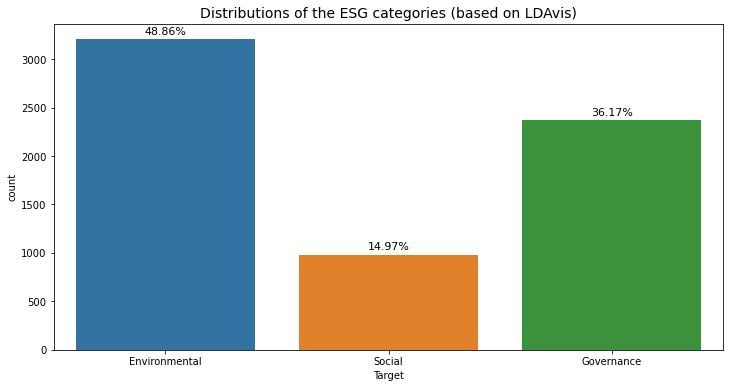

0    3205
2    2373
1     982
Name: ESG_category, dtype: int64


In [74]:
df_dType = pd.DataFrame({'Target' : topic_vecs_df['ESG_category']})
total_counts = len(topic_vecs_df)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Target', data=df_dType)
ax.set_title('Distributions of the ESG categories (based on LDAvis)', fontsize=14)
for rectBox in ax.patches:
    count = rectBox.get_height()
    print("Counts :", count)
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 50,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)

# Change the x-labels
plt.xticks(np.arange(3), ("Environmental", "Social", "Governance"))

plt.savefig('ESG_distributions_LDAvis', facecolor='w')
plt.show()

print(topic_vecs_df['ESG_category'].value_counts())

## 3.3 Feature Engineering and Context Association

> Assumption : ESG words in each category from the provided ESG word data file
> * Depending on highest matching ratio to create the target values (E=0, S=1, G=2)
> * Label the documents with targets to be used for training and predictions

In [75]:
test_list_words = test_lemmatized[0][:30]
topic_category, max_ratio = predict_doc_category(test_list_words)  # ['memory', 'dynamic', 'parallel', 'distribute', 'bit']

print("Test document filename : '{}'".format(test_pdf_filename))
print("Inferred topic category is '{}' based on maximum probability : {:.2f}%".format(topic_category, max_ratio*100))

Test document filename : 'LDAvis.pdf'
Inferred topic category is 'E' based on maximum probability : 3.30%


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
# Retrieve top words from topid_id and store in list for comparison with the ESG words
def get_top_list_words(top_num_words: int, top_topic_words: list):
    list_words = []
    
    for i in range(top_num_words):
        # print("Extracted word_{} : {}".format(i, top_topic_words[i][0]))
        list_words.append(top_topic_words[i][0])
    return list_words

topic_id = 0
top_num_words = 30
top_topic_words = lda_baselined_model.show_topic(topicid=topic_id, topn=top_num_words)

# Show the top 30 words from topicid = 0
top_list_words = get_top_list_words(top_num_words, top_topic_words)
print(top_list_words)

['object', 'visual', 'detection', 'segmentation', 'scene', 'motion', 'pixel', 'shape', 'human', 'video', 'face', 'location', 'frame', 'spatial', 'color', 'pose', 'category', 'patch', 'cvpr', 'computer_vision', 'segment', 'fig', 'match', 'position', 'hash', 'detector', 'vision', 'surface', 'track', 'depth']


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
%%time
train_vecs = []
max_prob_topic = []
top_num_words = 30

print("Creating vectors for {} samples...".format(len(papers_text_df)))
# For all papers
for i in range(len(papers_text_df)): # 6560
    top_topics = lda_baselined_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    
    # Get the topic distribution for each paper's text.
    topic_vec = [top_topics[j][1] for j in range(optimal_num_topics)]
        
    # Save the topic with highest probability for each paper
    topic_id, max_prob= max(top_topics, key=lambda item: item[1])
    # print('Maximum probability:', max_prob, "with topic:", topic_id)
    max_prob_topic.append(topic_id)
    
    # Extend with another feature vector, total characters in each document
    topic_vec.extend([len(papers_text_df.iloc[i].paper_text)])
    
    # Create labels (0-2) based on assumptions that highest word ratio belonging to a provided ESG category words
    # Label the documents with targets to be used for training and predictions
    top_topic_words = lda_baselined_model.show_topic(topicid=topic_id, topn=top_num_words)
    top_list_words = get_top_list_words(top_num_words, top_topic_words) 
    topic_category, max_ratio = predict_doc_category(top_list_words)
    
    if (topic_category == 'E'):
        # 1 : Environmental
        topic_vec.extend([0])
    elif (topic_category == 'S'):
        # 2 : Social
        topic_vec.extend([1])
    else: # topic_category == 'G'
        # 3 : Governance
        topic_vec.extend([2])
    
    train_vecs.append(topic_vec)
    

# Get the train_vecs to be used as features (7 topic vectors based on probability and paper text length)
print("No. of {} samples with {} features".format(len(train_vecs), len(train_vecs[0])))
print()
print("First 5 samples of vector features:\n{} ".format(train_vecs[:5]))

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating vectors for 6560 samples...
No. of 6560 samples with 14 features

First 5 samples of vector features:
[[0.26416627, 0.053932417, 0.00010796893, 0.2882255, 0.06810474, 0.0937608, 0.043823905, 0.058900427, 0.034659933, 0.012908198, 0.026414756, 0.054995056, 21643, 2], [0.00014569159, 0.00014569641, 0.00014569517, 0.24188825, 0.00014569073, 0.00014569034, 0.0001456912, 0.0047734124, 0.00014569757, 0.029630745, 0.72254205, 0.00014569706, 15505, 1], [9.2741604e-05, 9.274511e-05, 9.274379e-05, 0.07712979, 9.274517e-05, 0.0029547845, 9.2744114e-05, 9.274496e-05, 9.274378e-05, 9.27429e-05, 0.90819144, 0.01098201, 20523, 1], [0.00017656392, 0.00017656804, 0.38992268, 0.06899624, 0.000176564, 0.027771013, 0.47081998, 0.03432305, 0.00017656466, 0.0001765695, 0.007107633, 0.00017656724, 19441, 0], [0.00019174292, 0.06754477, 0.016759114, 0.00019174092, 0.02844694, 0.00019173839, 0.866341, 0.00019173729, 0.00019173951, 0.019566009, 0.0001917392, 0.00019173947, 20219, 0]] 
Wall time: 31.7 s

In [81]:
print("There are {} documents and the first 10 samples having topics with max prob :\n{}".format(len(max_prob_topic),
                                                                                                 max_prob_topic[:10]))

There are 6560 documents and the first 10 samples having topics with max prob :
[3, 10, 10, 6, 6, 0, 10, 3, 3, 3]


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
# Create dataframe for topic vectors, total_chars and ESG_category
topic_vecs_df = pd.DataFrame(train_vecs, columns=col_names)
topic_vecs_df[:10]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars,ESG_category
0,0.264166,0.053932,0.000108,0.288226,0.068105,0.093761,0.043824,0.058900,0.034660,0.012908,0.026415,0.054995,21643,2
1,0.000146,0.000146,0.000146,0.241888,0.000146,0.000146,0.000146,0.004773,0.000146,0.029631,0.722542,0.000146,15505,1
2,0.000093,0.000093,0.000093,0.077130,0.000093,0.002955,0.000093,0.000093,0.000093,0.000093,0.908191,0.010982,20523,1
3,0.000177,0.000177,0.389923,0.068996,0.000177,0.027771,0.470820,0.034323,0.000177,0.000177,0.007108,0.000177,19441,0
4,0.000192,0.067545,0.016759,0.000192,0.028447,0.000192,0.866341,0.000192,0.000192,0.019566,0.000192,0.000192,20219,0
5,0.378386,0.014984,0.110936,0.094038,0.000130,0.000130,0.071143,0.000130,0.000130,0.317644,0.000130,0.012218,22451,1
6,0.000207,0.000207,0.049128,0.160407,0.005050,0.000207,0.058862,0.000207,0.000207,0.240638,0.351084,0.133797,13053,1
7,0.006501,0.003319,0.000141,0.666157,0.107482,0.118448,0.089863,0.000141,0.000141,0.000141,0.007523,0.000141,17870,2
8,0.203139,0.000144,0.000144,0.708327,0.056702,0.015382,0.000144,0.000144,0.000144,0.015442,0.000144,0.000144,17312,2
9,0.079937,0.000075,0.000075,0.858047,0.045553,0.008572,0.000075,0.000075,0.000075,0.007369,0.000075,0.000075,31503,2


C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counts : 2636
Counts : 1747
Counts : 2177


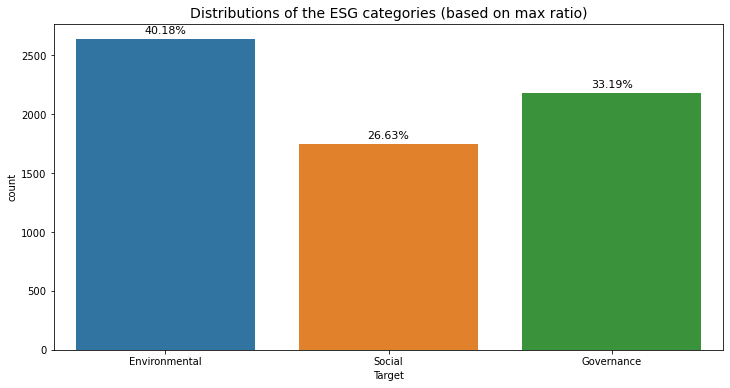

0    2636
2    2177
1    1747
Name: ESG_category, dtype: int64


In [83]:
df_dType = pd.DataFrame({'Target' : topic_vecs_df['ESG_category']})
total_counts = len(topic_vecs_df)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Target', data=df_dType)
ax.set_title('Distributions of the ESG categories (based on max ratio)', fontsize=14)
for rectBox in ax.patches:
    count = rectBox.get_height()
    print("Counts :", count)
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 50,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)

# Change the x-labels
plt.xticks(np.arange(3), ("Environmental", "Social", "Governance"))

plt.savefig('ESG_distributions_max_ratio', facecolor='w')
plt.show()

print(topic_vecs_df['ESG_category'].value_counts())

## 4. Multi-class Classifications

In [84]:
X = topic_vecs_df.drop(columns=['ESG_category'], axis=1)
y = topic_vecs_df['ESG_category']
X.shape, y.shape

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((6560, 13), (6560,))

In [87]:
!pip install lightgbm

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score
# pd.options.display_max_colums = 999

# Standardize features by removing the mean and scaling to unit variance does not have any difference
# std_scaler = StandardScaler()
# std_scaler.fit(X)
# X_scaled = pd.DataFrame(std_scaler.fit_transform(X))

# Train-Test-Split (0.7, 03)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # X_scaled

# Converting the dataset into LightGBM format
lgb_dataset = lgb.Dataset(X_train, label=y_train)
X_train

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars
6399,0.000118,0.000118,0.000118,0.101178,0.000118,0.000118,0.025043,0.000118,0.013312,0.000118,0.859524,0.000118,18966
5623,0.010343,0.126630,0.010835,0.000066,0.000066,0.000066,0.000066,0.057161,0.000185,0.000066,0.000066,0.794454,39820
5141,0.000064,0.006276,0.146823,0.020255,0.011930,0.438299,0.088076,0.067406,0.016479,0.134208,0.015869,0.054314,37581
6505,0.210943,0.000113,0.014596,0.089102,0.000113,0.027766,0.000113,0.010575,0.000113,0.000113,0.646340,0.000113,21404
4952,0.000095,0.000095,0.795480,0.000095,0.000095,0.000095,0.086600,0.044625,0.028131,0.000095,0.000095,0.044502,30527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.000104,0.076246,0.000104,0.000104,0.000104,0.000104,0.020717,0.902097,0.000104,0.000104,0.000104,0.000104,32650
5191,0.212784,0.000130,0.009279,0.203474,0.044700,0.036439,0.082769,0.000130,0.000130,0.402233,0.007801,0.000130,20124
5226,0.004698,0.656460,0.000089,0.193458,0.000089,0.004227,0.000089,0.059310,0.047321,0.000089,0.000089,0.034080,36551
5390,0.000159,0.000159,0.000159,0.734432,0.000159,0.000159,0.025764,0.000159,0.024000,0.194685,0.020006,0.000159,15469


In [89]:
lgb_params = {}
lgb_params['learning_rate']=0.03
lgb_params['boosting_type']='gbdt'      # Gradient Boosting Decision Tree as the base algorithm
lgb_params['objective'] = 'multiclass'  # Multi-class target
lgb_params['metric'] = 'multi_logloss'  # Metric for Multi-class Classification
lgb_params['max_depth'] = 10            # Max. depth for decision tree
lgb_params['num_class'] = 3             # No. of class
lgb_params

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learning_rate': 0.03,
 'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'max_depth': 10,
 'num_class': 3}

In [90]:
%%time
epochs = 100
lgbm_clf = lgb.train(lgb_params, lgb_dataset, epochs)
lgbm_clf

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4592, number of used features: 13
[LightGBM] [Info] Start training from score -0.927129
[LightGBM] [Info] Start training from score -1.327105
[LightGBM] [Info] Start training from score -1.081555
Wall time: 503 ms


In [91]:
# Prediction on the test set
y_pred = lgbm_clf.predict(X_test)
y_pred.shape

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1968, 3)

In [92]:
# Using no.argmax() to show the most probable class
y_pred = [np.argmax(pred) for pred in y_pred]
y_pred[:10]

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2, 1, 0, 1, 0, 1, 1, 2, 2, 0]

In [93]:
# Precision Score
precision_score(y_pred, y_test, average=None).mean()

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9749529284013093

In [94]:
papers_text_pred_df = pd.concat([papers_text_df, topic_vecs_df], axis=1)

# stack the columns in the second DataFrame to the RIGHT of the first DataFrame 
papers_text_pred_df

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,pdf_name,paper_text,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars,ESG_category
0,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,0.264166,0.053932,0.000108,0.288226,0.068105,0.093761,0.043824,0.058900,0.034660,0.012908,0.026415,0.054995,21643,2
1,A Mean Field Theory of Layer IV of Visual Cort...,10-a-mean-field-theory-of-layer-iv-of-visual-c...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,0.000146,0.000146,0.000146,0.241888,0.000146,0.000146,0.000146,0.004773,0.000146,0.029631,0.722542,0.000146,15505,1
2,Storing Covariance by the Associative Long-Ter...,100-storing-covariance-by-the-associative-long...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,0.000093,0.000093,0.000093,0.077130,0.000093,0.002955,0.000093,0.000093,0.000093,0.000093,0.908191,0.010982,20523,1
3,Bayesian Query Construction for Neural Network...,1000-bayesian-query-construction-for-neural-ne...,Bayesian Query Construction for Neural\nNetwor...,0.000177,0.000177,0.389923,0.068996,0.000177,0.027771,0.470820,0.034323,0.000177,0.000177,0.007108,0.000177,19441,0
4,"Neural Network Ensembles, Cross Validation, an...",1001-neural-network-ensembles-cross-validation...,"Neural Network Ensembles, Cross\nValidation, a...",0.000192,0.067545,0.016759,0.000192,0.028447,0.000192,0.866341,0.000192,0.000192,0.019566,0.000192,0.000192,20219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6555,Single Transistor Learning Synapses,994-single-transistor-learning-synapses.pdf,Single Transistor Learning Synapses\n\nPaul Ha...,0.000119,0.000119,0.000119,0.914775,0.052202,0.000119,0.000119,0.000119,0.000119,0.000119,0.031950,0.000119,18345,2
6556,"Bias, Variance and the Combination of Least Sq...",996-bias-variance-and-the-combination-of-least...,"Bias, Variance and the Combination of\nLeast S...",0.000148,0.612154,0.164188,0.100860,0.010527,0.000148,0.100197,0.000148,0.011188,0.000148,0.000148,0.000148,22944,0
6557,A Real Time Clustering CMOS Neural Engine,997-a-real-time-clustering-cmos-neural-engine.pdf,A Real Time Clustering CMOS\nNeural Engine\nT....,0.042571,0.000183,0.000183,0.823391,0.024403,0.019966,0.000183,0.000183,0.015099,0.027575,0.003478,0.042786,14731,2
6558,Learning direction in global motion: two class...,998-learning-direction-in-global-motion-two-cl...,Learning direction in global motion: two\nclas...,0.137806,0.000115,0.000115,0.025142,0.000115,0.000115,0.040040,0.005287,0.000115,0.000115,0.729861,0.061174,20421,1


In [95]:
papers_text_df.shape, topic_vecs_df.shape, papers_text_pred_df.shape

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((6560, 3), (6560, 14), (6560, 17))

In [96]:
# 3 main categories with can be mapped to "Environmental", "Social" and "Governance"
# Create file for predictions
def create_file_for_predictions(filename, pdf_name, predictions):    
    predictions_df = pd.DataFrame({'pdf_name': pdf_name, 'target': predictions})
    predictions_df.to_csv(filename, index=False)

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
# papers_text_df.columns, topic_vecs_df.columns start @ 16:43
create_file_for_predictions('pdf_name_ESG.csv', papers_text_pred_df['pdf_name'],
                            papers_text_pred_df['ESG_category'])

C:\NTU Tutorials\Year 1\Sem 2\Data Science and AI\DSAI\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## End of Program

In [97]:
# a_string = '!hi. wh?at is the weat[h]er lik?e.'
# new_string = re.sub(r'[\[,\\.!?\]]', '', a_string) # [^\w\s] except words and spaces
# new_string